# Job Shop Scheduling: Local Search

In the previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/notebooks/job-shop-scheduling-state-space-search.ipynb) on Job Shop Scheduling by State Space Search, we have introduced the basics of **job shop scheduling** and an AI planning **state space search** algorithm to find the best schedule with the minimal makespan.

The state space search algorithm searches all the possible goal states (schedules) exhaustively. Although the exhaustive search can guarantee optimality, its **computation complexity grows exponentially with the increase of the problem size**. Therefore, it is usually not possible to enumerate all the possible solutions / goal states to find the optimal solution.

> **NOTE**: The computational complexity of the state space exhaustive search is $O(N^{NM})$, where $N$ is the number of jobs and $M$ is the number of machines. The job shop scheduling problem is known as NP-hard, which means there is no exact method that can find the optimal schedule in polynomial time.

As the problem size increases, it is impossible to enumerate all the possible solutions. In this tutorial, we introduce how to use **local search** methods to search **ONLY a part** of the solution space, to find **good enough** solutions within **a reasonable time**. 

## Job Shop Scheduling

---

The job shop scheduling problem is described as follows. Given a set of $N$ jobs and $M$ machines, each job $i$ has a sequence of operations to be processed in order. Operation $j$ of job $i$ has a processing time $t_{ij}$ and needs to be processed by machine $m_{ij}$.

The problem is to design a schedule, i.e., the start time $x_{ij}$ of each operation on its machine, so that the objective function (e.g., makespan and tardiness) of the schedule is minimised, and the following contraints are satisfied.

1. **Resource Constraint**: each machine can process at most one operation at a time.
2. **Precedence Constraint**: each operation cannot start processing until its precedent operation in the same job has been completed. The first operation of a job can be started at time 0 (the job is already at the shop floor).

An example of the job shop scheduling is shown as two matrices below, where element $[i,j]$ corresponds to $t_{ij}$ and $m_{ij}$, respectively.

- Operation processing time $t_{ij}$:

| t_ij | 0 | 1 | 2 |
| --- |---|---|---|
| 0 | 30 | 30 | 10 |
| 1 | 60 | 15 | 10 | 

- Operation machine $m_{ij}$:

| m_ij | 0 | 1 | 2 |
| --- |---|---|---|
| 0 | 0 | 1 | 2 |
| 1 | 0 | 1 | 2 | 

An example schedule is shown as a matrix of $x_{ij}$, such as

| x_ij | 0 | 1 | 2 |
| --- |---|---|---|
| 0 | 0 | 30 | 60 |
| 1 | 30 | 90 | 105 | 

<img src="img/simple-schedule.png" width=600 />

## Solution Representation

---

The solution representation is very important to determine the search space and how effective the search will be. There have been many different representation schemes for job shop scheduling. Here, we adopt a common representation called the **preference list-based** representation.

> **NOTe**: more representations can be found in this [paper](https://www.sciencedirect.com/science/article/pii/0360835296000472).

In the **preference list-based** representation, a scheduling solution is represented as a set of preference lists, each for one machine. The preference list of a machine is a permutation of operations, indicating the order of operations the machine will process if they are ready.

The preference list-based representation is an **encoding** of the schedules, and it requires a **decoding** scheme to obtain the corresponding schedule, i.e., the start times $x_{ij}$.

For example, the schedule shown above can be represented as follows under the preference list-based representation.

In [1]:
pref_lists = [[(0,0), (1,0)],
              [(0,1), (1,1)],
              [(0,2), (1,2)]]

### Decoding

The decoding is very similar to the [state space search](https://github.com/meiyi1986/tutorials/blob/master/notebooks/job-shop-scheduling-state-space-search.ipynb). 

1. In the **initial state**, the schedule is empty, all machines are idle at time 0 and the first operation of each job is ready at time 0. All other operations are not ready to be processed.
2. At each state, we find the **next actions** `Process(op, machine, t)` as follows.
    1. `op` must be ready at time `t`, and `machine` must be idle at time `t`. 
    2. `t` is the earliest time to start processing `op` on `machine`.
    3. The index of `op` among the uncompleted operations in the preference list of `machine` must be minimum. That is, we first check the first uncompleted operation in the preference lists. If no operation is ready, then we check the second, until we find at least one ready uncompleted operation.

The code of the decoding of a solution under the preference list-based representation is as follows.

In [2]:
import numpy as np
import copy

def preference_list_decoding(pref_lists, t_mtx, m_mtx):
    num_jobs, num_machines = t_mtx.shape # Get the number of jobs and number of machines
    num_ops = num_jobs * num_machines # Total number of operations
    x_mtx = np.zeros([num_jobs, num_machines]) # Initialise the schedule, starting time of each operation
    
    machine_idle_time = np.zeros(num_machines) # Each machine is initially idle at time 0
    op_ready_time = [(0, 0) for i in range(num_jobs)] # For each job, the first operation 0 is ready at time 0
    
    rem_ops = copy.deepcopy(pref_lists) # The operations remaining uncompleted
    num_completed_ops = 0 # Number of completed operations, stop when reaching N * M
    
    while num_completed_ops < num_ops:
        # Find the next actions: the ready operations with the minimum index in rem_ops
        next_actions = []
        for l in range(num_jobs): # l is the current index of preference list to be checked
            for k in range(num_machines):
                if l >= len(rem_ops[k]):
                    continue
                
                (i, j) = rem_ops[k][l]
                if op_ready_time[i][0] == j:
                    next_actions.append((k, l))

            if len(next_actions) > 0:
                break
        
        # Apply the next action for each machine k
        for (k, l) in next_actions:
            (i, j) = rem_ops[k][l] # Get the operation to be processed
            # Calculate the action time
            action_t = op_ready_time[i][1]
            if machine_idle_time[k] > action_t:
                action_t = machine_idle_time[k]
            
            x_mtx[i, j] = action_t
            rem_ops[k].pop(l)
            num_completed_ops = num_completed_ops + 1
            
            finish_time = action_t + t_mtx[i, j]
            if j < num_machines - 1:
                op_ready_time[i] = (j+1, finish_time)
            machine_idle_time[k] = finish_time
    
    return x_mtx

We apply this decoding to the above simple example. Given the $t_{ij}$ and $m_{ij}$ matrices and the solution as preference lists, we can obtain the corresponding $x_{ij}$ matrix.

In [3]:
t_mtx = np.array([[30, 30, 10],
                  [60, 15, 10]])

m_mtx = np.array([[0, 1, 2],
                  [0, 1, 2]])

pref_lists = [[(0,0), (1,0)],
              [(0,1), (1,1)],
              [(0,2), (1,2)]]

x_mtx = preference_list_decoding(pref_lists, t_mtx, m_mtx)

print(x_mtx)

[[  0.  30.  60.]
 [ 30.  90. 105.]]


## Evaluation

---

The solution evaluation depends on the objective function. Here, we consider **minimising makespan**. Given a $x_{ij}$ matrix, we can calculate the makespan based on $x_{ij}$ and the processing time $t_{ij}$ as follows.

In [4]:
def makespan(x_mtx, t_mtx):
    return max([x_mtx[i, -1] + t_mtx[i, -1] for i in range(len(x_mtx))])

Thus, the evaluation of a preference list-based solution is as follows.

In [5]:
def evaluate(pref_lists, t_mtx, m_mtx):
    x_mtx = preference_list_decoding(pref_lists, t_mtx, m_mtx)
    return makespan(x_mtx, t_mtx), x_mtx

## Local Search

---

### Framework

Here, we consider a simple hill-climbing local search algorithm, whose framework is given as follows.

In [6]:
import time

def local_search_jss(t_mtx, m_mtx, initialisation, nb_selection, seed):
    '''
    The local search framework for solving job shop scheduling.
    :param t_mtx, m_mtx: The processing time and machine matrices of the problem.
    :param initialisation: The initialisation method.
    :param nb_selection: The neighbour selection method.
    :param seed: the random seed, if the local search is a stochastic search.
    :return: The final solution and the log, which stores the elapsed time and best obj so far after each iteration.
    '''
    
    log = {'time': [], 'obj': []} # The log [elapse_time, best_obj]
    start = time.time()
    
    sol, sol_x_mtx, sol_obj = initialisation(t_mtx, m_mtx, seed)
    
    improved = True
    while improved:
        improved = False

        nb, nb_x_mtx, nb_obj = nb_selection(sol, sol_x_mtx, sol_obj, t_mtx, m_mtx, seed)
        
        if sol_obj - nb_obj > 0.0000000001:
            sol, sol_x_mtx, sol_obj = nb, nb_x_mtx, nb_obj
            improved = True

        end = time.time()
        log['time'].append(end-start)
        log['obj'].append(sol_obj)

    return sol, sol_x_mtx, sol_obj, log

### Initialisation

We can randomly initialise the preference lists by randomly shuffling the lists.

In [7]:
def random_pref_lists(t_mtx, m_mtx, seed):
    num_jobs, num_machines = t_mtx.shape
    
    pref_lists = [[] for k in range(num_machines)]
    for i in range(num_jobs):
        for j in range(num_machines):
            pref_lists[m_mtx[i,j]].append((i,j))
    
    np.random.seed(seed)
    for pl in pref_lists:
        np.random.shuffle(pl)
    
    obj, x_mtx = evaluate(pref_lists, t_mtx, m_mtx)
    
    return pref_lists, x_mtx, obj

### Neighbour Selection

Under the preference list-based representation, we can **define the neighbourhood** based on the **operation swap** operator, i.e., to swap the operations at position $i$ and position $j$ in the preference list of machine $k$. The neighbourhood is defined as the set of solutions that can be applied by applying the operation swap operator with all possible $(i, j, k)$ parameters. The neighbourhood size is $O(N^2M)$, where $N$ is the number of jobs and $M$ is the number of machines.

The operation swap operator is shown as follows.

In [8]:
def op_swap(pref_lists, i, j, k):
    tmp = pref_lists[k][i]
    pref_lists[k][i] = pref_lists[k][j]
    pref_lists[k][j] = tmp

We use the **best improvement** neighbor selection, i.e., select the best neighbour in the neighbourhood. The best improvement operation swap neighbour selection is shown below.

In [9]:
def op_swap_best_improvement(sol, sol_x_mtx, sol_obj, t_mtx, m_mtx, seed):
    num_jobs, num_machines = t_mtx.shape
    
    best_nb, best_nb_x_mtx, best_nb_obj = sol, sol_x_mtx, sol_obj
    
    for k in range(num_machines):
        for i in range(num_jobs-1):
            for j in range(i+1, num_jobs):
                nb = copy.deepcopy(sol)
                op_swap(nb, i, j, k)
                nb_obj, nb_x_mtx = evaluate(nb, t_mtx, m_mtx)
                
                if nb_obj < best_nb_obj:
                    best_nb, best_nb_x_mtx, best_nb_obj = nb, nb_x_mtx, nb_obj
    
    return best_nb, best_nb_x_mtx, best_nb_obj

## Case Study: Taillard JSP Instance

---

Here, we test the local search on a `data/15_15_1.jsp` Taillard JSP instance. It has 15 jobs and 15 machines. First, we load the data, i.e., the $t_{ij}$ and $m_{ij}$ matrices, as follows.

In [10]:
def load_data(file):

    """
    Read a JSP instance from a .jsp file, and returns the t_mtx and m_mtx.
    :param file: the .jsp file.
    :return: t_mtx and m_mtx
    """

    f = open(file, "r")
    
    f.readline() # Skip the head row
    
    num_jobs = f.readline().lstrip().split()[0] # Read the first element, number of jobs
    num_jobs = int(num_jobs)
    
    # Skip until the time matrix
    line = f.readline()
    while not line.__contains__("Times"):
        line = f.readline()

    # Read the time matrix
    t_mtx = []
    
    for i in range(num_jobs):
        line = f.readline().lstrip().rstrip()
        row = [float(e) for e in line.split()]
        t_mtx.append(row)
        
    f.readline() # Skip the line "Machines"

    # Read the machine matrix
    m_mtx = []
    
    for i in range(num_jobs):
        line = f.readline().lstrip().rstrip()
        row = [int(e) for e in line.split()]
        m_mtx.append(row)

    f.close()

    return np.array(t_mtx), np.array(m_mtx)-1

In [11]:
t_mtx, m_mtx = load_data("data/15_15_1.jsp")

print(t_mtx)
print(m_mtx)

[[94. 66. 10. 53. 26. 15. 65. 82. 10. 27. 93. 92. 96. 70. 83.]
 [74. 31. 88. 51. 57. 78.  8.  7. 91. 79. 18. 51. 18. 99. 33.]
 [ 4. 82. 40. 86. 50. 54. 21.  6. 54. 68. 82. 20. 39. 35. 68.]
 [73. 23. 30. 30. 53. 94. 58. 93. 32. 91. 30. 56. 27. 92.  9.]
 [78. 23. 21. 60. 36. 29. 95. 99. 79. 76. 93. 42. 52. 42. 96.]
 [29. 61. 88. 70. 16. 31. 65. 83. 78. 26. 50. 87. 62. 14. 30.]
 [18. 75. 20.  4. 91. 68. 19. 54. 85. 73. 43. 24. 37. 87. 66.]
 [32. 52.  9. 49. 61. 35. 99. 62.  6. 62.  7. 80.  3. 57.  7.]
 [85. 30. 96. 91. 13. 87. 82. 83. 78. 56. 85.  8. 66. 88. 15.]
 [ 5. 59. 30. 60. 41. 17. 66. 89. 78. 88. 69. 45. 82.  6. 13.]
 [90. 27.  1.  8. 91. 80. 89. 49. 32. 28. 90. 93.  6. 35. 73.]
 [47. 43. 75.  8. 51.  3. 84. 34. 28. 60. 69. 45. 67. 58. 87.]
 [65. 62. 97. 20. 31. 33. 33. 77. 50. 80. 48. 90. 75. 96. 44.]
 [28. 21. 51. 75. 17. 89. 59. 56. 63. 18. 17. 30. 16.  7. 35.]
 [57. 16. 42. 34. 37. 26. 68. 73.  5.  8. 12. 87. 83. 20. 97.]]
[[ 6 12  4  7  3  2 10 11  8 14  9 13  5  0  1]
 [ 4  

Then, we use local search to find the solution (here we arbitrarily set the random seed to 1).

In [12]:
ls_sol, ls_x_mtx, ls_obj, ls_log = local_search_jss(t_mtx, 
                                                    m_mtx, 
                                                    random_pref_lists, 
                                                    op_swap_best_improvement, 
                                                    1)

## Display the Schedule

---

Here we display the Gantt chart of the schedule obtained by the local search as follows.

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def gantt_chart(x_mtx, t_mtx, m_mtx):
    num_jobs, num_machines = x_mtx.shape

    makespan = max(x_mtx[:,-1] + t_mtx[:,-1])

    # Declaring a figure "gnt"
    fig, gnt = plt.subplots(figsize=(10+(num_jobs+num_machines)/4, 5))

    # Setting Y-axis limits
    gnt.set_ylim(0, 10 * num_machines + 10)

    # Setting X-axis limits
    gnt.set_xlim(0, makespan * 1.05)

    # Setting labels for x-axis and y-axis
    gnt.set_xlabel('Time')
    gnt.set_ylabel('Machine')

    # Setting ticks on y-axis
    gnt.set_yticks([10 * k + 5 for k in range(num_machines)])
    # Labelling tickes of y-axis
    gnt.set_yticklabels(list(range(num_machines)))

    # Setting graph attribute
    gnt.grid(True)

    colors = mpl.cm.Dark2.colors

    for i in range(num_jobs):
        for j in range(num_machines):
            k = m_mtx[i,j]
            gnt.broken_barh([(x_mtx[i,j], t_mtx[i,j])], (10 * k, 9), facecolors = colors[i%7])

    gnt.text(makespan, gnt.get_ylim()[0]-2, "{0:0.1f}".format(makespan), ha='center', va='top')
    gnt.plot([makespan]*2, gnt.get_ylim(), 'r--')

    plt.show()

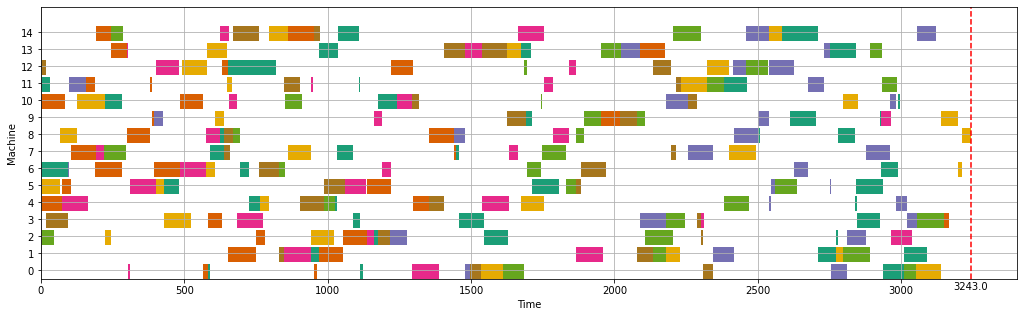

In [14]:
gantt_chart(ls_x_mtx, t_mtx, m_mtx)

## Convergence Curve

---

We then plot the convergence curve of the local search process as follows. We can see that the local search is a bit slow, it takes about 35 seconds to complete.

In [15]:
def plot_convergence_curves(logs, names, title):
    fig, ax = plt.subplots()
    curves = []
    
    for log in logs:
        curve, = plt.plot(log['time'], log['obj'])
        curves.append(curve)
    
    plt.legend(curves, names)
    
    ax.set_xlabel("time (second)")
    ax.set_ylabel("obj")
    
    plt.title(title)
    plt.show()

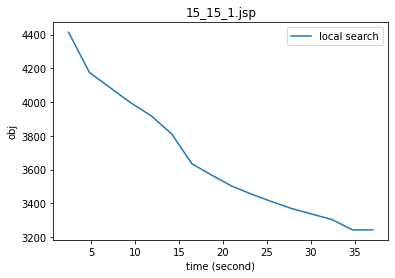

In [16]:
plot_convergence_curves([ls_log], ['local search'], '15_15_1.jsp')

---

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)